In [2]:
# Run brainscore encoder with Object2Vec for single and all subjects
import h5py
import pickle
import numpy as np
import xarray as xr
from brainio.fetch import get_stimulus_set
from model_tools.brain_transformation.neural import LayerMappedModel
from brainscore.metrics.regression import linear_regression
from bonner.models.alexnet_imagenet import alexnet_imagenet # PytorchWrapper
from bonner.brainscore.benchmarks.bonner2021_object2vec import load_assembly, N_SUBJECTS, extract_features
from src.utils import listdir


/home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/brainscore/metrics/__init__.py:39: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


In [3]:
# Define a BrainModel
model = LayerMappedModel(
    identifier="alexnet-imagenet-features.8",
    activations_model=alexnet_imagenet(batch_size=256),
    region_layer_map={None: "features.8"},
    visual_degrees=None,
)

# Define ROI tuple
rois = (
    "FFA",
    "PPA",
    "LOC",
    "EBA",
    "EVC",
)

# Load Object2Vec stimuli
stimulus_set = get_stimulus_set(("bonner2021.object2vec-texture"))

# Extract features
model_assembly = extract_features(model, stimulus_set)


Loading lookup from entrypoints
Loading lookup from /home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/bonner/brainscore/lookup.csv
Loading lookup from /home/chan21/.conda/envs/bonner-lab-kelsey/lib/python3.7/site-packages/brainscore/lookup.csv


In [4]:
# Load neural assembly for S1
# subject = 0
# neural_assembly = load_assembly(
#     subject,
#     average_reps= True,
#     z_score=True,
#     check_integrity=False,
#     kwargs_filter={
#         "rois": rois,
#     }
# )

# # Concatenated neural assembly
concatenated_neural_assembly = xr.concat(
    [
        load_assembly(
        subject,
        average_reps=True,
        z_score=False,
        check_integrity=False,
        kwargs_filter={
            "rois": rois
        }
    )
    .drop_vars("cv_set")
     for subject in range(N_SUBJECTS)
    ],
    dim="neuroid", # Concatenate along this dimension
)





In [5]:
betas = {}
for roi in rois:
    betas[roi] = {}
    for backend in ("sklearn", "pytorch"):
        regression = linear_regression(backend=backend)
        regression.fit(
            source=model_assembly,
            target=concatenated_neural_assembly.sel(
                {
                    "neuroid": concatenated_neural_assembly[f"roi_{roi}"].astype(bool).values
                }
            )
        )
    betas[roi][backend] = {
        "coef_": regression._regression.coef_,
        "intercept_": regression._regression.intercept_,
        "rank_": regression._regression.rank_,
        "singular_": regression._regression.singular_,
    }
    
# check dimension
betas['FFA']['pytorch']['coef_'].shape

torch.Size([3136, 43264])

In [81]:
# Get activations for Things face stim
stim_path = "../../visualsemantic/stimuli/face-things"
stim_images = listdir(stim_path)

face_activations = alexnet_imagenet()(
    [ci for ci in stim_images], layers=["features.8"], stimuli_identifier="face-things-features.8"
)


activations:   0%|          | 0/64 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

In [93]:
# Get activatinos for best Murty stim
layers = ["features.8"]

f = h5py.File('../../visualsemantic/stimuli/L2_data.mat','r')
L2data = f.get('L2_data')
print(L2data.keys())
L2data_rois = (L2data.get('rois'))


condition_idx = {
                "place": np.concatenate((np.arange(76,101), np.arange(126,151)), axis=None),
                "body": np.concatenate((np.arange(1,26), np.arange(101,126)), axis=None),
                "object": np.concatenate((np.arange(51,76), np.arange(151,186)), axis=None)}

conditions = list(condition_idx.keys())
pooled_obs = np.array(L2data.get('pooled_obs'))
pooled_pred = np.array(L2data.get('pooled_pred'))

best_face = np.stack((pooled_pred[:, 0], pooled_pred[:, 1]), axis=1).mean(axis=1).argsort()[-10:][::-1]
best_body = np.stack((pooled_pred[:, 2], pooled_pred[:, 3]), axis=1).mean(axis=1).argsort()[-10:][::-1]
best_place = np.stack((pooled_pred[:, 4], pooled_pred[:, 5]), axis=1).mean(axis=1).argsort()[-10:][::-1]
best_object = condition_idx["object"][:10]

condition_best_idx = {
                      "body": best_body,
                      "place": best_place,
                     "object": best_object}

condition_path = "../../visualsemantic/stimuli/murty-stimuli"
stim_images = listdir(condition_path)

for condition in conditions:
    condition_imgs[condition] = [stim_images[idx] for idx in condition_best_idx[condition]]

condition = 'place'
scene_activations = alexnet_imagenet()(
    [ci for ci in condition_imgs[condition]], layers=layers, stimuli_identifier="murty_scene_." + " ".join(layers)
)
condition = 'body'
body_activations = alexnet_imagenet()(
    [ci for ci in condition_imgs[condition]], layers=layers, stimuli_identifier="murty_body_." + " ".join(layers)
)

condition = 'object'
object_activations = alexnet_imagenet()(
    [ci for ci in condition_imgs[condition]], layers=layers, stimuli_identifier="murty_object_." + " ".join(layers)
)

<KeysViewHDF5 ['pooled_composite', 'pooled_obs', 'pooled_pred', 'rois', 'subj_obs', 'subj_pred']>


activations:   0%|          | 0/64 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

activations:   0%|          | 0/64 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

activations:   0%|          | 0/64 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

In [97]:
cond_activations = {'face': face_activations.values,
                   'place': scene_activations.values,
                   'body': body_activations.values,
                   'object': object_activations.values}

In [98]:
conditions = list(cond_activations.keys())
cond_predicted = {roi: {cond: [] for cond in conditions} for roi in rois}

for roi in rois:
    for condition in conditions:
        data = cond_activations[condition]
        content_predicted = np.matmul(data, betas[roi]['pytorch']['coef_'].T)
        print(roi, condition, content_predicted.mean())
        cond_predicted[roi][condition] = content_predicted
    

FFA face tensor(0.0124)
FFA place tensor(0.0228)
FFA body tensor(0.0284)
FFA object tensor(0.1164)
PPA face tensor(-0.5015)
PPA place tensor(0.1695)
PPA body tensor(-0.2255)
PPA object tensor(-0.1266)
LOC face tensor(0.0290)
LOC place tensor(0.1259)
LOC body tensor(0.1259)
LOC object tensor(0.1792)
EBA face tensor(0.3744)
EBA place tensor(0.2312)
EBA body tensor(0.3787)
EBA object tensor(0.3058)
EVC face tensor(-0.6293)
EVC place tensor(-0.1169)
EVC body tensor(-0.4614)
EVC object tensor(-0.1764)


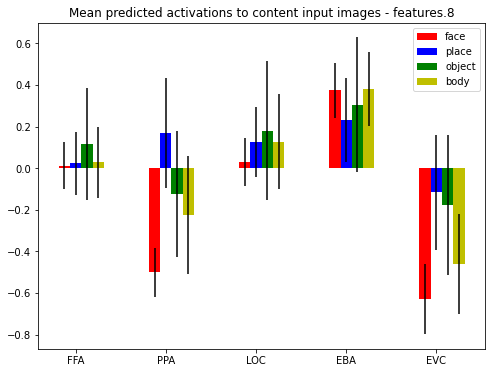

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plot mean predicted activations to input images
plt.figure(figsize=(8,6))
plt.title("Mean predicted activations to content input images - " + "".join(layers))
X = np.array([0, 1, 2, 3, 4])
plt.bar(X + 0.00,
        [cond_predicted['FFA']['face'].mean(axis=1).mean(),
         cond_predicted['PPA']['face'].mean(axis=1).mean(),
         cond_predicted['LOC']['face'].mean(axis=1).mean(),
         cond_predicted['EBA']['face'].mean(axis=1).mean(),
         cond_predicted['EVC']['face'].mean(axis=1).mean()],
         color='r',
         yerr=[np.std(cond_predicted['FFA']['face'].mean(axis=1).numpy()),
                np.std(cond_predicted['PPA']['face'].mean(axis=1).numpy()),
                np.std(cond_predicted['LOC']['face'].mean(axis=1).numpy()),
                np.std(cond_predicted['EBA']['face'].mean(axis=1).numpy()),
                np.std(cond_predicted['EVC']['face'].mean(axis=1).numpy())
         ],
        width=0.125,
       label='face')

plt.bar(X + 0.125,
        [cond_predicted['FFA']['place'].mean(axis=1).mean(),
         cond_predicted['PPA']['place'].mean(axis=1).mean(),
         cond_predicted['LOC']['place'].mean(axis=1).mean(),
         cond_predicted['EBA']['place'].mean(axis=1).mean(),
        cond_predicted['EVC']['place'].mean(axis=1).mean()],
       color='b',
        yerr=[np.std(cond_predicted['FFA']['place'].mean(axis=1).numpy()),
                np.std(cond_predicted['PPA']['place'].mean(axis=1).numpy()),
                np.std(cond_predicted['LOC']['place'].mean(axis=1).numpy()),
                np.std(cond_predicted['EBA']['place'].mean(axis=1).numpy()),
                np.std(cond_predicted['EVC']['place'].mean(axis=1).numpy())
         ],
       width=0.125,
       label='place')

plt.bar(X + 0.25,
        [cond_predicted['FFA']['object'].mean(axis=1).mean(),
         cond_predicted['PPA']['object'].mean(axis=1).mean(),
         cond_predicted['LOC']['object'].mean(axis=1).mean(),
         cond_predicted['EBA']['object'].mean(axis=1).mean(),
         cond_predicted['EVC']['object'].mean(axis=1).mean()
        ],
       color='g',
        yerr=[np.std(cond_predicted['FFA']['object'].mean(axis=1).numpy()),
                np.std(cond_predicted['PPA']['object'].mean(axis=1).numpy()),
                np.std(cond_predicted['LOC']['object'].mean(axis=1).numpy()),
                np.std(cond_predicted['EBA']['object'].mean(axis=1).numpy()),
                np.std(cond_predicted['EVC']['object'].mean(axis=1).numpy())
         ],
       width=0.125,
       label='object')

plt.bar(X + 0.375,
        [cond_predicted['FFA']['body'].mean(axis=1).mean(),
         cond_predicted['PPA']['body'].mean(axis=1).mean(),
         cond_predicted['LOC']['body'].mean(axis=1).mean(),
         cond_predicted['EBA']['body'].mean(axis=1).mean(),
        cond_predicted['EVC']['body'].mean(axis=1).mean()],
       color='y',
        yerr=[np.std(cond_predicted['FFA']['body'].mean(axis=1).numpy()),
                np.std(cond_predicted['PPA']['body'].mean(axis=1).numpy()),
                np.std(cond_predicted['LOC']['body'].mean(axis=1).numpy()),
                np.std(cond_predicted['EBA']['body'].mean(axis=1).numpy()),
                np.std(cond_predicted['EVC']['body'].mean(axis=1).numpy())
         ],
       width=0.125,
       label='body')

plt.xticks(X+0.125, ['FFA', 'PPA', 'LOC', 'EBA', 'EVC'])
_ = plt.legend()

#plt.savefig("/home/chan21/projects/visualsemantic/results/encbaselineaverage_" + layers[0] + ".png")

# for roi in rois:
#     plt.figure()
#     plt.title(roi + " " + "".join(layers))
#     sns.distplot(cond_predicted[roi]['face'], hist=False, kde=True, 
#                  color = 'r',
#                  kde_kws = {'linewidth': 3},
#                 label = "face")
#     sns.distplot(cond_predicted[roi]['place'], hist=False, kde=True, 
#              color = 'b',
#              kde_kws = {'linewidth': 3},
#             label = "scene")
#     sns.distplot(cond_predicted[roi]['object'], hist=False, kde=True, 
#                  color = 'g',
#                  kde_kws = {'linewidth': 3},
#                 label = "object")
#     sns.distplot(cond_predicted[roi]['body'], hist=False, kde=True, 
#              color = 'y',
#              kde_kws = {'linewidth': 3},
#             label = "body")
#     _ = plt.legend()
    

In [9]:
# Get activations for classic-Konkle stim

layers = ["features.8"]
conditions = ['bodies', 'buildings', 'cats', 'chairs', 'faces', 'hammers', 'phones']
condition_imgs = {cond: [] for cond in conditions}
condition_path = "../../visualsemantic/stimuli/classic-konkle"
stim_images = listdir(condition_path)

for condition in conditions:
    condition_imgs[condition] = [stim for stim in stim_images if condition in stim]

    
cond_activations = {cond: [] for cond in conditions}
for condition in conditions:
    cond_activations[condition] = alexnet_imagenet()(
    [ci for ci in condition_imgs[condition]], layers=layers, stimuli_identifier="classic_konkle_" + condition + "." + " ".join(layers)
    )

In [114]:
cond_predicted = {roi: {cond: [] for cond in conditions} for roi in rois}

for roi in rois:
    for condition in conditions:
        data = cond_activations[condition]
        content_predicted = np.matmul(data, betas[roi]['pytorch']['coef_'].T)
        print(roi, condition, content_predicted.mean())
        cond_predicted[roi][condition] = content_predicted
    

FFA bodies tensor(-0.0568)
FFA buildings tensor(-0.0795)
FFA cats tensor(-0.0955)
FFA chairs tensor(-0.0606)
FFA faces tensor(-0.0587)
FFA hammers tensor(-0.0829)
FFA phones tensor(-0.0934)
PPA bodies tensor(0.0212)
PPA buildings tensor(0.0556)
PPA cats tensor(0.0210)
PPA chairs tensor(0.0449)
PPA faces tensor(-0.0384)
PPA hammers tensor(-0.0865)
PPA phones tensor(-0.0618)
LOC bodies tensor(0.0466)
LOC buildings tensor(0.0064)
LOC cats tensor(-0.0273)
LOC chairs tensor(0.0645)
LOC faces tensor(0.0197)
LOC hammers tensor(0.0083)
LOC phones tensor(-0.0356)
EBA bodies tensor(0.1254)
EBA buildings tensor(0.0580)
EBA cats tensor(0.0437)
EBA chairs tensor(0.1357)
EBA faces tensor(0.1056)
EBA hammers tensor(0.1152)
EBA phones tensor(0.0278)
EVC bodies tensor(-0.1107)
EVC buildings tensor(-0.0786)
EVC cats tensor(-0.0855)
EVC chairs tensor(-0.1101)
EVC faces tensor(-0.1271)
EVC hammers tensor(-0.1547)
EVC phones tensor(-0.1071)


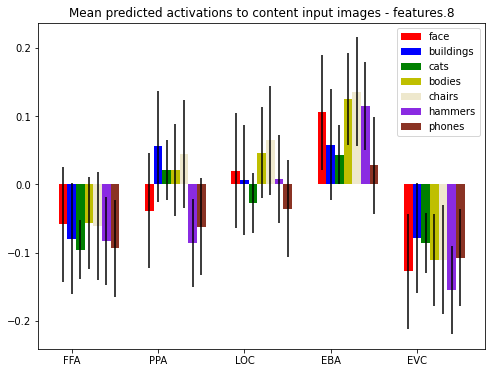

In [36]:
with open("../results/0415_konkle/predicted_features.8.pkl", 'rb') as pickle_file:
    cond_predicted = pickle.load(pickle_file)
    
# Plot mean predicted activations to input images
plt.figure(figsize=(8,6))
plt.title("Mean predicted activations to content input images - " + "".join(layers))
X = np.array([0, 1, 2, 3, 4])
plt.bar(X + 0.00,
        [cond_predicted['FFA']['faces'].mean(axis=1).mean(),
         cond_predicted['PPA']['faces'].mean(axis=1).mean(),
         cond_predicted['LOC']['faces'].mean(axis=1).mean(),
         cond_predicted['EBA']['faces'].mean(axis=1).mean(),
         cond_predicted['EVC']['faces'].mean(axis=1).mean()],
       color='r',
       yerr=
        [np.std(cond_predicted['FFA']['faces'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['faces'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['faces'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['faces'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['faces'].mean(axis=1).numpy())],
        width=0.1,
       label='face')

plt.bar(X + 0.1,
        [cond_predicted['FFA']['buildings'].mean(axis=1).mean(),
         cond_predicted['PPA']['buildings'].mean(axis=1).mean(),
         cond_predicted['LOC']['buildings'].mean(axis=1).mean(),
         cond_predicted['EBA']['buildings'].mean(axis=1).mean(),
        cond_predicted['EVC']['buildings'].mean(axis=1).mean()],
        yerr=
        [np.std(cond_predicted['FFA']['buildings'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['buildings'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['buildings'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['buildings'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['buildings'].mean(axis=1).numpy())],
       color='b',
       width=0.1,
       label='buildings')

plt.bar(X + 0.2,
        [cond_predicted['FFA']['cats'].mean(axis=1).mean(),
         cond_predicted['PPA']['cats'].mean(axis=1).mean(),
         cond_predicted['LOC']['cats'].mean(axis=1).mean(),
         cond_predicted['EBA']['cats'].mean(axis=1).mean(),
         cond_predicted['EVC']['cats'].mean(axis=1).mean()
        ],
        yerr=
        [np.std(cond_predicted['FFA']['cats'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['cats'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['cats'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['cats'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['cats'].mean(axis=1).numpy())],
       color='g',
       width=0.1,
       label='cats')

plt.bar(X + 0.3,
        [cond_predicted['FFA']['bodies'].mean(axis=1).mean(),
         cond_predicted['PPA']['bodies'].mean(axis=1).mean(),
         cond_predicted['LOC']['bodies'].mean(axis=1).mean(),
         cond_predicted['EBA']['bodies'].mean(axis=1).mean(),
        cond_predicted['EVC']['bodies'].mean(axis=1).mean()],
        yerr=
        [np.std(cond_predicted['FFA']['bodies'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['bodies'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['bodies'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['bodies'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['bodies'].mean(axis=1).numpy())],
       color='y',
       width=0.1,
       label='bodies')

plt.bar(X + 0.4,
        [cond_predicted['FFA']['chairs'].mean(axis=1).mean(),
         cond_predicted['PPA']['chairs'].mean(axis=1).mean(),
         cond_predicted['LOC']['chairs'].mean(axis=1).mean(),
         cond_predicted['EBA']['chairs'].mean(axis=1).mean(),
        cond_predicted['EVC']['chairs'].mean(axis=1).mean()],
        yerr=
        [np.std(cond_predicted['FFA']['chairs'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['chairs'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['chairs'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['chairs'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['chairs'].mean(axis=1).numpy())],
       color='#EEE8CD',
       width=0.1,
       label='chairs')

plt.bar(X + 0.5,
        [cond_predicted['FFA']['hammers'].mean(axis=1).mean(),
         cond_predicted['PPA']['hammers'].mean(axis=1).mean(),
         cond_predicted['LOC']['hammers'].mean(axis=1).mean(),
         cond_predicted['EBA']['hammers'].mean(axis=1).mean(),
        cond_predicted['EVC']['hammers'].mean(axis=1).mean()],
        yerr=
        [np.std(cond_predicted['FFA']['hammers'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['hammers'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['hammers'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['hammers'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['hammers'].mean(axis=1).numpy())],
       color='#8A2BE2',
       width=0.1,
       label='hammers')

plt.bar(X + 0.6,
        [cond_predicted['FFA']['phones'].mean(axis=1).mean(),
         cond_predicted['PPA']['phones'].mean(axis=1).mean(),
         cond_predicted['LOC']['phones'].mean(axis=1).mean(),
         cond_predicted['EBA']['phones'].mean(axis=1).mean(),
        cond_predicted['EVC']['phones'].mean(axis=1).mean()],
        yerr=
        [np.std(cond_predicted['FFA']['phones'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['phones'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['phones'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['phones'].mean(axis=1).numpy()),
         np.std(cond_predicted['FFA']['phones'].mean(axis=1).numpy())],
       color='#8A3324',
       width=0.1,
       label='phones')

plt.xticks(X+0.1, ['FFA', 'PPA', 'LOC', 'EBA', 'EVC'])
_ = plt.legend()

plt.savefig("/home/chan21/projects/visualsemantic/results/encbaselineaverage_" + layers[0] + ".png")


In [37]:
# Konkle scenes by size and clutterness

konkscene_conditions = ["2-1-elevator", "2-3-restroom", "3-1-garage", "3-3-japaneseroom", "4-1-loft", "4-3-lobby"]

for k in konkscene_conditions:
    conditions.append(k)
konkscene_path =  "../../visualsemantic/stimuli/scene-konkle"
konkscenestim_images = listdir(konkscene_path)

for k in konkscene_conditions:
    condition_imgs[k] = [stim for stim in konkscenestim_images if k in stim]
    
for k in konkscene_conditions:
    cond_activations[k] = alexnet_imagenet()(
    [ci for ci in condition_imgs[k]], layers=layers, stimuli_identifier="scene_konkle_" + k + "." + " ".join(layers)
    )

for roi in rois:
    for k in konkscene_conditions:
        data = cond_activations[k].values
        content_predicted = np.matmul(data, betas[roi]['pytorch']['coef_'].T)
        print(roi, k, content_predicted.mean())
        cond_predicted[roi][k] = content_predicted
    

FFA 2-1-elevator tensor(0.2525)
FFA 2-3-restroom tensor(-0.0196)
FFA 3-1-garage tensor(-0.1604)
FFA 3-3-japaneseroom tensor(0.0508)
FFA 4-1-loft tensor(-0.0214)
FFA 4-3-lobby tensor(-0.1105)
PPA 2-1-elevator tensor(0.3529)
PPA 2-3-restroom tensor(0.0638)
PPA 3-1-garage tensor(0.0914)
PPA 3-3-japaneseroom tensor(0.3066)
PPA 4-1-loft tensor(0.2163)
PPA 4-3-lobby tensor(0.2898)
LOC 2-1-elevator tensor(0.2729)
LOC 2-3-restroom tensor(-0.0171)
LOC 3-1-garage tensor(-0.1198)
LOC 3-3-japaneseroom tensor(-0.0025)
LOC 4-1-loft tensor(0.0280)
LOC 4-3-lobby tensor(-0.0660)
EBA 2-1-elevator tensor(0.4418)
EBA 2-3-restroom tensor(0.1829)
EBA 3-1-garage tensor(0.0780)
EBA 3-3-japaneseroom tensor(0.2224)
EBA 4-1-loft tensor(0.1724)
EBA 4-3-lobby tensor(-0.0161)
EVC 2-1-elevator tensor(-0.4138)
EVC 2-3-restroom tensor(-0.4821)
EVC 3-1-garage tensor(-0.3892)
EVC 3-3-japaneseroom tensor(-0.6247)
EVC 4-1-loft tensor(-0.2695)
EVC 4-3-lobby tensor(-0.0827)


In [10]:
# Get activations for Konkle scenes attacked with Things face
stim_path = "../../visualsemantic/results/adversary/0415/"
stim_images = listdir(stim_path)
for stim in stim_images:
    if ".pt" in stim:
        stim_images.remove(stim)

scene_konkle_conditions = ["2-1-elevator", "4-1-loft", "4-3-lobby", "3-3-japaneseroom"]
attacked_activations = {k: [] for k in scene_konkle_conditions}
for k in scene_konkle_conditions:
    attacked_activations[k] = alexnet_imagenet()(
        [ci for ci in stim_images if k in ci], layers=["features.8"], stimuli_identifier="face_" + k + "-features.8"
    )
    
# Get predictions
attacked_predicted = {roi: {cond: [] for cond in scene_konkle_conditions} for roi in rois}
for roi in rois:
    for k in scene_konkle_conditions:
        data = attacked_activations[k].values
        content_predicted = np.matmul(data, betas[roi]['pytorch']['coef_'].T)
        print(roi, k, content_predicted.mean())
        attacked_predicted[roi][k] = content_predicted

FFA 2-1-elevator tensor(-0.0787)
FFA 4-1-loft tensor(-0.0243)
FFA 4-3-lobby tensor(-0.1041)
FFA 3-3-japaneseroom tensor(-0.0315)
PPA 2-1-elevator tensor(-0.1719)
PPA 4-1-loft tensor(-0.2647)
PPA 4-3-lobby tensor(-0.2217)
PPA 3-3-japaneseroom tensor(-0.1065)
LOC 2-1-elevator tensor(0.0121)
LOC 4-1-loft tensor(0.0302)
LOC 4-3-lobby tensor(0.0214)
LOC 3-3-japaneseroom tensor(0.0048)
EBA 2-1-elevator tensor(0.1114)
EBA 4-1-loft tensor(0.1063)
EBA 4-3-lobby tensor(0.1193)
EBA 3-3-japaneseroom tensor(0.0385)
EVC 2-1-elevator tensor(-0.1748)
EVC 4-1-loft tensor(-0.0701)
EVC 4-3-lobby tensor(-0.0982)
EVC 3-3-japaneseroom tensor(-0.0515)


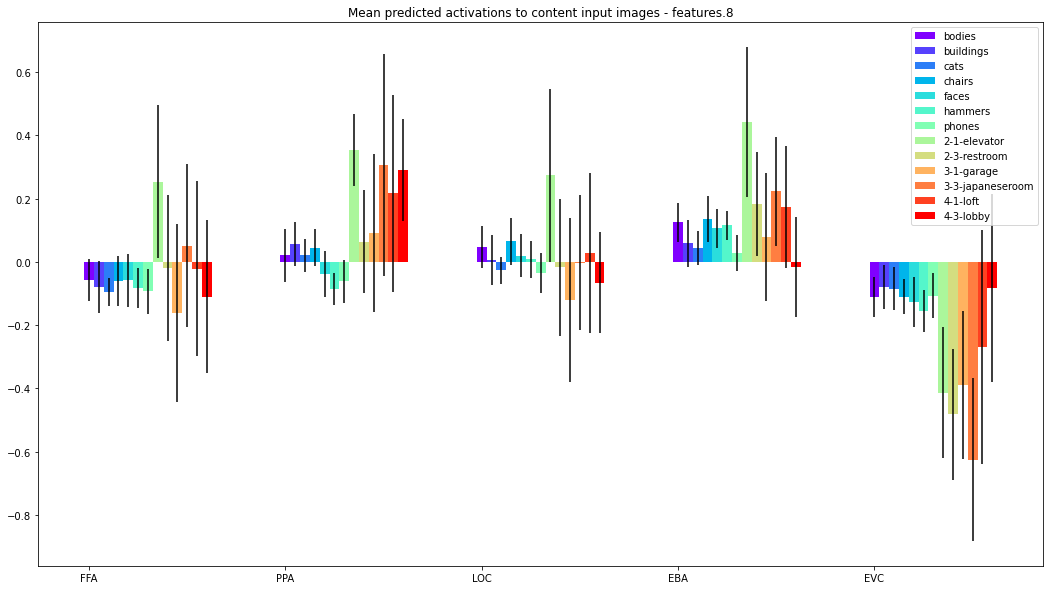

In [42]:
from matplotlib import cm

# Plot mean predicted activations to input images

num_colors = len(conditions)
colors = cm.rainbow(np.linspace(0,1,num_colors))

plt.figure(figsize=(18,10))
plt.title("Mean predicted activations to content input images - " + "".join(layers))
X = np.arange(5)

for i in range(len(conditions)):
    plt.bar(X + 0.05*i,
            [cond_predicted['FFA'][conditions[i]].mean(axis=1).mean(),
             cond_predicted['PPA'][conditions[i]].mean(axis=1).mean(),
             cond_predicted['LOC'][conditions[i]].mean(axis=1).mean(),
             cond_predicted['EBA'][conditions[i]].mean(axis=1).mean(),
             cond_predicted['EVC'][conditions[i]].mean(axis=1).mean()],
           width=0.05,
            yerr=[
                np.std(cond_predicted['FFA'][conditions[i]].mean(axis=1).numpy()),
                np.std(cond_predicted['PPA'][conditions[i]].mean(axis=1).numpy()),
                np.std(cond_predicted['LOC'][conditions[i]].mean(axis=1).numpy()),
                np.std(cond_predicted['EBA'][conditions[i]].mean(axis=1).numpy()),
                np.std(cond_predicted['EVC'][conditions[i]].mean(axis=1).numpy())],
           color=colors[i],
           label=conditions[i])

plt.xticks(X, ['FFA', 'PPA', 'LOC', 'EBA', 'EVC'])
_ = plt.legend()

#plt.savefig("/home/chan21/projects/visualsemantic/results/encbaselineaverage_" + layers[0] + ".png")


In [43]:
# Get activations for Konkle classic attacked with Things face
stim_path = "../../visualsemantic/results/adversary/"
stim_images = listdir(stim_path)
for stim in stim_images:
    if ".pt" in stim:
        stim_images.remove(stim)

classic_konkle_conditions = ["buildings"]
classic_attacked_activations = {k: [] for k in classic_konkle_conditions}
for k in classic_konkle_conditions:
    classic_attacked_activations[k] = alexnet_imagenet()(
        [ci for ci in stim_images if k in ci], layers=["features.8"], stimuli_identifier="face_" + k + "-features.8"
    )
    
# Get predictions
classic_attacked_predicted = {roi: {cond: [] for cond in classic_konkle_conditions} for roi in rois}
for roi in rois:
    for k in classic_konkle_conditions:
        data = classic_attacked_activations[k].values
        content_predicted = np.matmul(data, betas[roi]['pytorch']['coef_'].T)
        print(roi, k, content_predicted.mean())
        classic_attacked_predicted[roi][k] = content_predicted

activations:   0%|          | 0/64 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

FFA buildings tensor(-0.0690)
PPA buildings tensor(0.0083)
LOC buildings tensor(0.0109)
EBA buildings tensor(0.0373)
EVC buildings tensor(0.0193)


In [46]:
conditions = [              'bodies',
 'buildings',
 'cats',
 'chairs',
 'faces',
 'hammers',
 'phones']

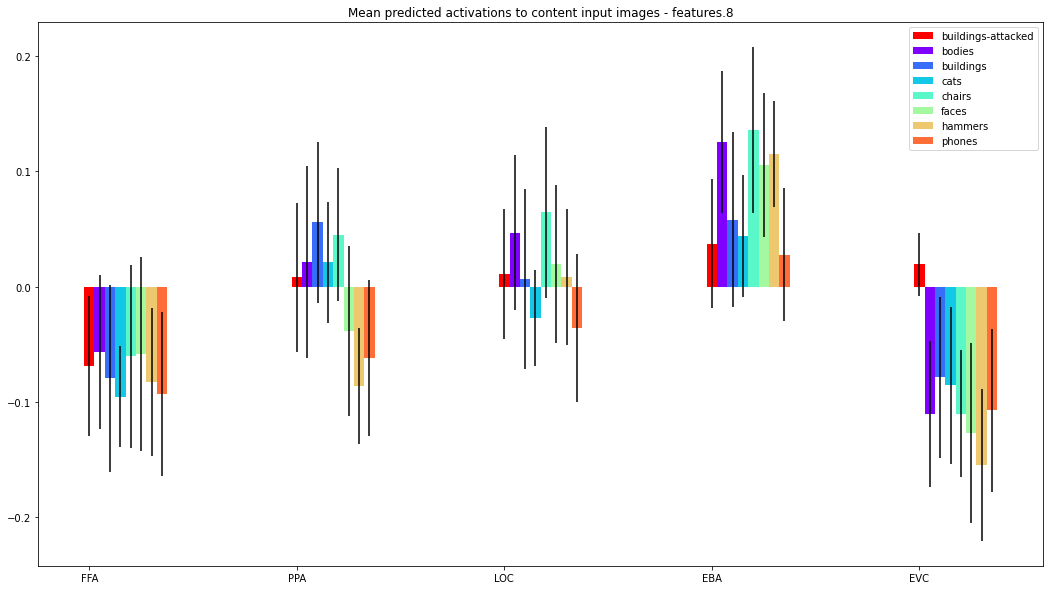

In [51]:
from matplotlib import cm
# Plot mean predicted activations to input images

num_colors = len(conditions)+1
colors = cm.rainbow(np.linspace(0,1,num_colors))

plt.figure(figsize=(18,10))
plt.title("Mean predicted activations to content input images - " + "".join(layers))
X = np.arange(5)

plt.bar(X + 0.0,
            [classic_attacked_predicted['FFA']['buildings'].mean(axis=1).mean(),
             classic_attacked_predicted['PPA']['buildings'].mean(axis=1).mean(),
             classic_attacked_predicted['LOC']['buildings'].mean(axis=1).mean(),
             classic_attacked_predicted['EBA']['buildings'].mean(axis=1).mean(),
             classic_attacked_predicted['EVC']['buildings'].mean(axis=1).mean()],
           width=0.05,
            yerr=[
                np.std(classic_attacked_predicted['FFA']['buildings'].mean(axis=1).numpy()),
                np.std(classic_attacked_predicted['PPA']['buildings'].mean(axis=1).numpy()),
                np.std(classic_attacked_predicted['LOC']['buildings'].mean(axis=1).numpy()),
                np.std(classic_attacked_predicted['EBA']['buildings'].mean(axis=1).numpy()),
                np.std(classic_attacked_predicted['EVC']['buildings'].mean(axis=1).numpy())],
           color=colors[-1],
           label="buildings-attacked")

for i in range(len(conditions)):
    plt.bar(X + 0.05+0.05*i,
            [cond_predicted['FFA'][conditions[i]].mean(axis=1).mean(),
             cond_predicted['PPA'][conditions[i]].mean(axis=1).mean(),
             cond_predicted['LOC'][conditions[i]].mean(axis=1).mean(),
             cond_predicted['EBA'][conditions[i]].mean(axis=1).mean(),
             cond_predicted['EVC'][conditions[i]].mean(axis=1).mean()],
           width=0.05,
            yerr=[
                np.std(cond_predicted['FFA'][conditions[i]].mean(axis=1).numpy()),
                np.std(cond_predicted['PPA'][conditions[i]].mean(axis=1).numpy()),
                np.std(cond_predicted['LOC'][conditions[i]].mean(axis=1).numpy()),
                np.std(cond_predicted['EBA'][conditions[i]].mean(axis=1).numpy()),
                np.std(cond_predicted['EVC'][conditions[i]].mean(axis=1).numpy())],
           color=colors[i],
           label=conditions[i])

plt.xticks(X, ['FFA', 'PPA', 'LOC', 'EBA', 'EVC'])
_ = plt.legend()

#plt.savefig("/home/chan21/projects/visualsemantic/results/encbaselineaverage_" + layers[0] + ".png")


In [74]:
# MIN_R = 0.1841

# neural_assembly_splitR = neural_assembly.isel({"neuroid": neural_assembly["splitR"] >= MIN_R})

# neural_assembly_splitR_sorted = neural_assembly_splitR.sortby(neural_assembly_splitR["contrast_scrambled"])